# Whose was best?
Finding the best model for each galaxy

### Problem:

*Given a set of GZ:B classifications for a galaxy, determine which classification produced the best residuals*

First, say the jupyter magic words 🧙‍

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from shapely.affinity import rotate, scale, translate
from descartes import PolygonPatch
from pprint import pprint
import lib.python_model_renderer.parse_annotation as pa
import lib.python_model_renderer.render_galaxy as rg
import lib.galaxy_utilities as gu

In [3]:
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

Which subject should we work on? (parametrised to allow batch running at a later date)

In [4]:
subject_id = 20902040

Implement a temporary way of reading in data till the zooniverse CSV export is fixed:

In [5]:
with open('../component-clustering/tmp_cls_dump.json') as f:
    classifications = json.load(f)
classifications_for_subject = [
    c for c in classifications
    if c['links']['subjects'][0] == str(subject_id)
]
print('Found {} classifications for subject_id {}'.format(
    len(classifications_for_subject),
    subject_id,
))
annotations_for_subject = [i['annotations'] for i in classifications_for_subject]

Found 32 classifications for subject_id 20902040


Grab the galaxy data (and classification data) for this galaxy

In [6]:
print('Getting galaxy data')
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
# classifications = gu.classifications
# classifications_for_subject = classifications['subject_ids'] == subject_id
# annotations_for_subject = [
#     eval(foo) for foo in
#     classifications_for_subject
# ]

Getting galaxy data


/Users/tlingard/PhD/galaxy-builder/data-aggregation/model-scoring/lib/galaxy_utilities.py:100: UserWarning: Using montaged image
  __import__('warnings').warn('Using montaged image')


Get the PSF and raw FITS data for this galaxy cutout (bundle with the Zooniverse subject)

In [7]:
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']

Define some useful goodies for plotting later (to transform from image coordinates to arcseconds from centre of galaxy)

In [8]:
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4) # arcseconds per pixel for zooniverse image
pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4) # arcseconds per pixel for galaxy data

def transform_coords(c):
    return (c - galaxy_data.shape[0] /2) / pix_size2
    
def transform_patch(p):
    return scale(
        translate(p, xoff=-pic_array.shape[0]/2, yoff=-pic_array.shape[1]/2),
        xfact=1/pix_size,
        yfact=1/pix_size,
        origin=(0, 0),
    )
imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        -pic_array.shape[0]/2 / pix_size, # left of image in arcseconds from centre
        pic_array.shape[0]/2 / pix_size, # right...
        -pic_array.shape[1]/2 / pix_size, # bottom...
        pic_array.shape[1]/2 / pix_size # top...
    ),
}

Pre-create a list of all pixels to calculate spiral distances for (optional but encouraged as the alternative is an approximation
which breaks for small distances)

In [9]:
point_list = [
    Point(i, j)
    for j in range(galaxy_data.shape[0])
    for i in range(galaxy_data.shape[0])
]

For each classification, calculate the drawn model and accompanying residual and save the two

In [25]:
import time
residuals = np.zeros(len(annotations_for_subject))
print('Calculating residuals...')
try:
    from ipywidgets import FloatProgress
    from IPython.display import display
    f = FloatProgress(min=0, max=100)
    display(f)
except Exeption:
    f = False
model_array = np.zeros((len(annotations_for_subject), diff_data['width'], diff_data['width']))
t0 = time.time()
for i, annotation in enumerate(annotations_for_subject):
    if f is not False:
        f.value = i
    parsed_annotation = pa.parse_annotation(annotation, size_diff=size_diff)
    model = rg.render_galaxy(parsed_annotation, diff_data['width'], point_list=point_list)
    model_array[i] = model
    difference_data = rg.compare_to_galaxy(model, psf, galaxy_data)
    residuals[i] = np.sum(difference_data**2)/np.multiply.reduce(galaxy_data.shape)
print('done in ', time.time() - t0)

Calculating residuals...


FloatProgress(value=0.0)

done in  23.55202889442444


Let's have a look at these residual scores.

Note these are not the 0-100 scores shown to users, to get from these to those use

$$
S = 100 \exp\left(-300\sum_{i=0}^n(\text{model}_i-\text{image}_i)^2\right).
$$

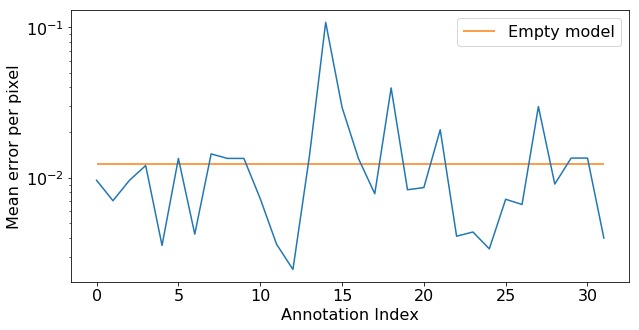

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.ylabel('Mean error per pixel')
plt.xlabel('Annotation Index')
plt.hlines(np.sum(galaxy_data)/np.multiply.reduce(galaxy_data.shape), 0, len(residuals)-1, 'C1', label='Empty model')
plt.legend()
plt.yscale('log')

Which index was the best?

In [27]:
print('Best index:', np.argmin(residuals))

Best index: 12


Let's have a look at the six most successful models

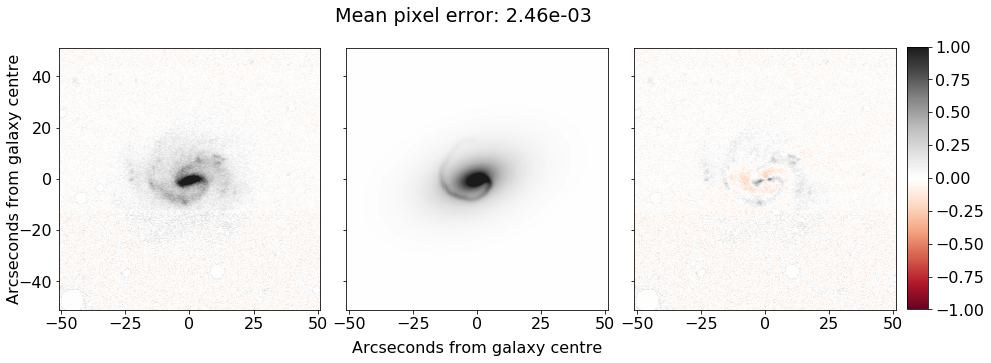

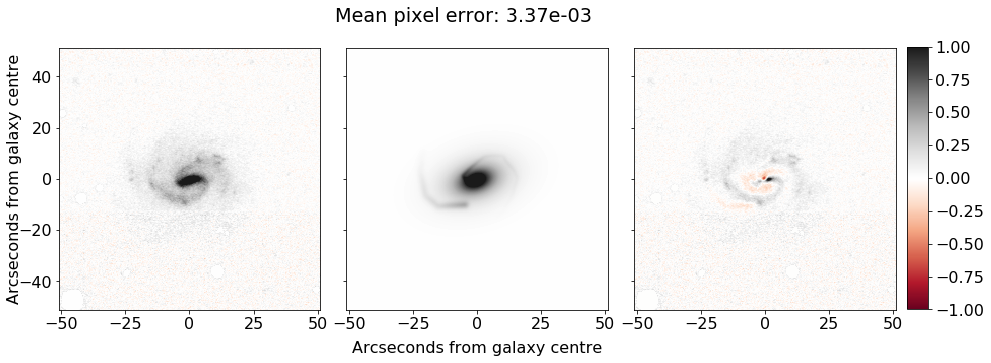

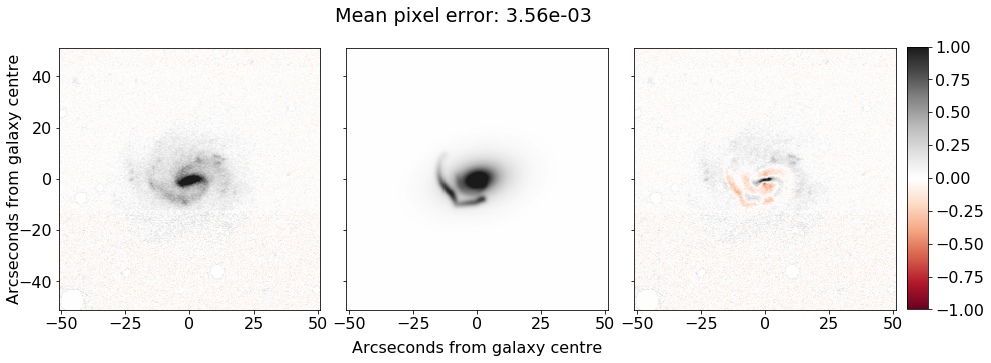

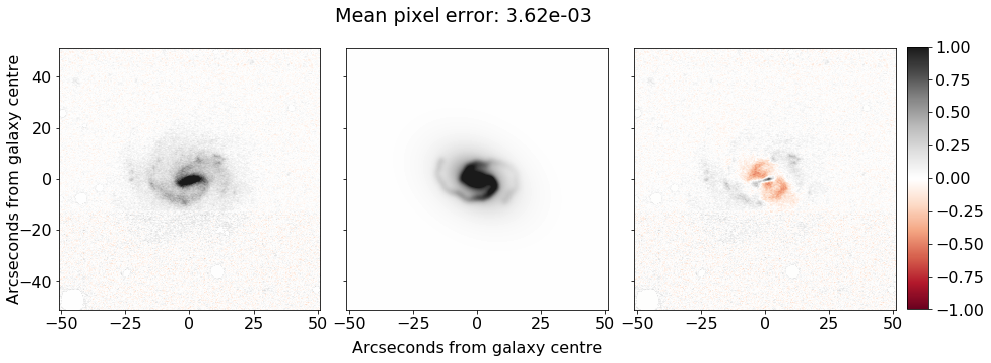

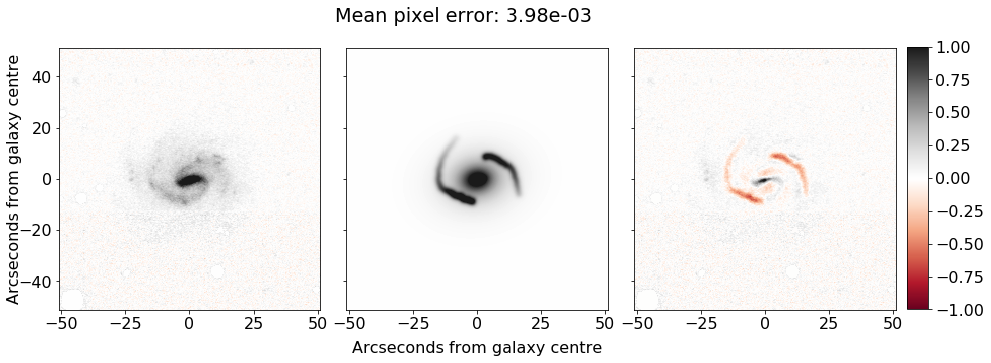

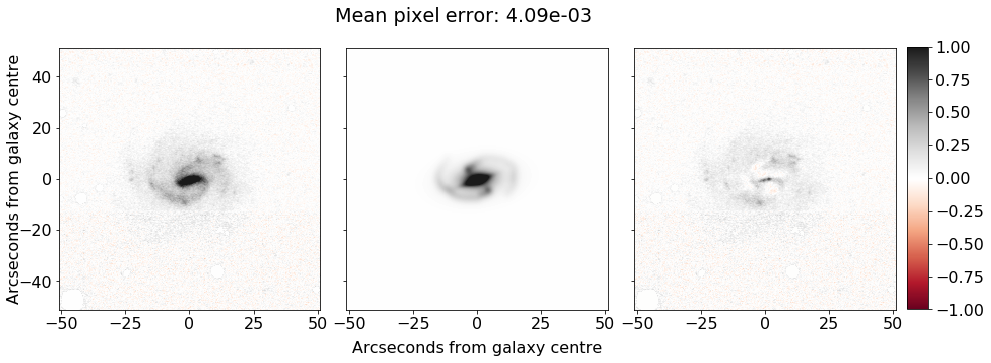

In [28]:
indices = np.argsort(residuals)[:6]
for i, model in enumerate(model_array[indices]):
    rg.plot_model(model, psf, galaxy_data, imshow_kwargs=imshow_kwargs, title='Mean pixel error: {:.2e}'.format(
        np.array(residuals)[indices][i]
    ))

## And the winner is...

In [29]:
best_annotation = annotations_for_subject[np.argmin(residuals)]
best_annotation_parsed = pa.parse_annotation(best_annotation, size_diff=size_diff)

In [30]:
model = rg.render_galaxy(
    best_annotation_parsed,
    diff_data['width'], point_list=point_list
)

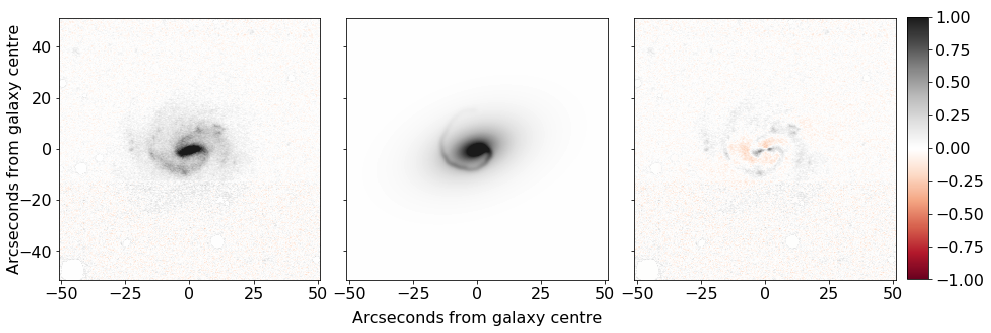

In [31]:
difference_data = rg.plot_model(model, psf, galaxy_data, imshow_kwargs=imshow_kwargs)

B. E. A. Utiful

Let's see what the shapes drawn looked like:

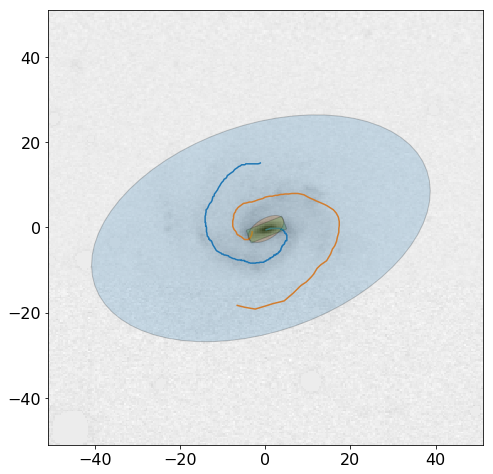

In [32]:
geoms = []
for func, comp in (
    (gu.ellipse_geom_from_zoo, best_annotation[0]),
    (gu.ellipse_geom_from_zoo, best_annotation[1]),
    (gu.bar_geom_from_zoo, best_annotation[2]),
):
    try:
        geoms.append(func(comp['value'][0]['value'][0]))
    except IndexError:
        pass
plt.figure(figsize=(8, 8))
plt.imshow(galaxy_data, **imshow_kwargs)
for i, geom in enumerate(geoms):
    plt.gca().add_patch(
        PolygonPatch(transform_patch(geom), fc='C{}'.format(i), ec='k', alpha=0.2, zorder=3)
    )
for points, params in best_annotation_parsed['spiral']:
    plt.plot(*transform_coords(points).T)

And there we have it!